# Autoencoders vs. PCA


COGS 118B: Introduction to Machine Learning II - Final Project

Nick DeGroot (A15949734)

# Introduction

In class, we learned about Principal Component Analysis (PCA) as a dimensionality reduction algorithm. PCA works by first finding the directions of greatest variance, defined by the eigenvectors associated with the largest eigenvalues. These directions are then used to project the data onto a lower-dimensional space through a linear transformation. We call the transformed data the "principal components" of the original data, as they represent the most important features of the data.

Later in class, we learned about Neural Networks and their power in modeling non-linear data. Neural networks work by taking in a set of inputs, passing them through a series of layers, and then outputting a result. The layers are composed of neurons, which are connected to each other and to the inputs. The neurons are activated by a weighted sum of their inputs, and the weights are adjusted during training to minimize the error between the output and the desired output. The layers are trained in a process called backpropagation, where the error is propagated backwards through the network to adjust the weights.

However, in researching more about neural networks, I stumbled across the idea of **autoencoders**.

![](./figures/autoencoder.png)

The idea for autoencoders was created by the PDP group back in 1986 and published as _Learning Internal Representations by Error Propagation_ (Rumelhart et al., 1986). The idea behind them is conceptually pretty simple. On the surface, an autoencoder is the same as any other neural network. Inputs are passed through the network through its layers and optimized via backpropagation. However, the structure of the autoencoder is one where the inputs are "squeezed" through a low-dimensionality middle layer. We call the layers that lead up to this point the "encoder", and the layers that lead away from this point the "decoder".

If we make the output layer the same shape as the input layer, we can choose an error function that penalizes the difference between the input and the output. This causes the model to attempt to reconstruct the input from the output. This is the main idea behind autoencoders: they are neural networks that attempt to reconstruct their inputs _through a lower-dimensionality bottleneck_.

After training the model, we can essentially throw away the decoder and use the encoder as a dimensionality reduction algorithm. In essence, the encoder becomes a non-linear PCA.

# Dataset

To showcase how autoencoders and PCA differ, let's use the MNIST dataset. This dataset contains 70,000 images of handwritten digits, each 28x28 pixels. The goal is to classify each image as one of the 10 digits.

We specifically use the `torchvision` version, which contains more then the `sklearn` version.

In [2]:
from sklearn.decomposition import PCA
from torchvision.datasets import MNIST

data_dir = '../data/raw/'    
dataset = MNIST(data_dir, train=True, download=True)

# PCA

With `scikit-learn`, it's easy to train a PCA model. We simply need to instantiate a `PCA` object, and then call `fit` on the data. In the background, this does everything we learned in class.

Let's use 2 components, so we can visualize the data in 2D.

In [3]:
n_components = 2
pca = PCA(n_components=n_components)

data = dataset.data.numpy()
data = data.reshape(-1, 28 * 28)  # Need to reshape into flattened array for PCA
pca.fit(data)

PCA(n_components=2)

With the model trained, we can visualize what their principal components look like.

In [4]:
test_dataset = MNIST(data_dir, train=False, download=True)

<AxesSubplot: >

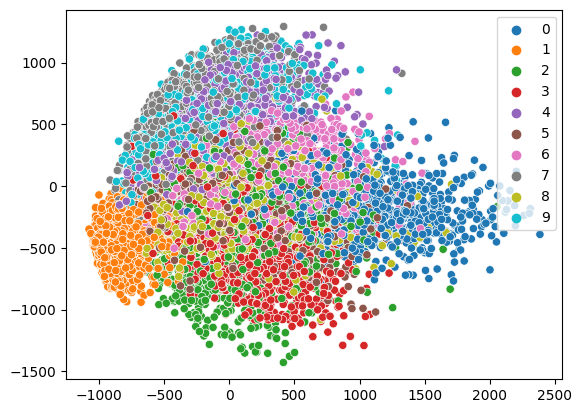

In [5]:
import seaborn as sns
pc = pca.transform(test_dataset.data.numpy().reshape(-1, 28 * 28))
sns.scatterplot(x=pc[:, 0], y=pc[:, 1], hue=test_dataset.targets, palette='tab10')

Not bad! We can generally see each digit lives in its own cluster, meaning a clustering algorithm should be able to classify the data. However, we can see that the 2D projection is not perfect. For example, the 1s and 7s are mixed together, and the 4s and 9s are mixed together.

Let's see if we can do better with an autoencoder.

# Autoencoders

[PyTorch](https://pytorch.org/) is a popular deep learning framework with a lot of built-in functionality for neural networks. It allows us to focus on the structure of the network, while it takes care of things like gradient calculations, backpropagation, and optimization.

[PyTorch Lightning](https://www.pytorchlightning.ai/) is a framework built on top of PyTorch that automates certain tasks, like training and validation loops. It also provides a lot of built-in functionality for common tasks, like logging and checkpointing.

While it's possible to create autoencoders in native PyTorch, we will use PyTorch Lightning to simplify the logic.

In [6]:
from autoencoder_mnist.data.mnist_loader import MNISTLoader

# Custom DataLoader that wraps the same MNIST seen earlier 
dm = MNISTLoader(data_dir, batch_size=1048, num_workers=12)

Now, let's define our model infrastructure. Even with PyTorch Lightning there's still a bit of boilerplate code, so I've abstracted it away inside a module. If you're interested in the actual details, you can check out the [`autoencoder_mnist/models/autoencoder_fc.py`](https://github.com/nickthegroot/autoencoder-mnist/blob/main/autoencoder_mnist/models/autoencoder_fc.py) file

In [7]:
from autoencoder_mnist.models.autoencoder_fc import AutoencoderFC
from pytorch_lightning.utilities.model_summary import ModelSummary

n_components = 2
model = AutoencoderFC(n_components, 1e-3)
ModelSummary(model, max_depth = 1)

  | Name    | Type       | Params | In sizes       | Out sizes  
----------------------------------------------------------------------
0 | encoder | Sequential | 109 K  | [1, 1, 28, 28] | [1, 2]     
1 | decoder | Sequential | 110 K  | [1, 2]         | [1, 28, 28]
----------------------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.879     Total estimated model params size (MB)

We can see two parts to the model: the encoder and decoder. As explained, the encoder takes the original $(28, 28)$ image and squeezes it down to a lower $(2)$ dimensionality representation, while the decoder brings it right back up to a $(28, 28)$ image. Note that the leading $(1)$ is the batch size.

Let's dig into what each part is actually composed of.

In [8]:
ModelSummary(model, max_depth = 2)

   | Name      | Type       | Params | In sizes       | Out sizes  
-------------------------------------------------------------------------
0  | encoder   | Sequential | 109 K  | [1, 1, 28, 28] | [1, 2]     
1  | encoder.0 | Flatten    | 0      | [1, 1, 28, 28] | [1, 784]   
2  | encoder.1 | Linear     | 100 K  | [1, 784]       | [1, 128]   
3  | encoder.2 | ReLU       | 0      | [1, 128]       | [1, 128]   
4  | encoder.3 | Linear     | 8.3 K  | [1, 128]       | [1, 64]    
5  | encoder.4 | ReLU       | 0      | [1, 64]        | [1, 64]    
6  | encoder.5 | Linear     | 780    | [1, 64]        | [1, 12]    
7  | encoder.6 | ReLU       | 0      | [1, 12]        | [1, 12]    
8  | encoder.7 | Linear     | 26     | [1, 12]        | [1, 2]     
9  | decoder   | Sequential | 110 K  | [1, 2]         | [1, 28, 28]
10 | decoder.0 | Linear     | 36     | [1, 2]         | [1, 12]    
11 | decoder.1 | ReLU       | 0      | [1, 12]        | [1, 12]    
12 | decoder.2 | Linear     | 832    | [1,

The encoder is composed of 7 layers. Looking closer, however, we notice that it's only made up of three trainable layers (`Linear`). The `Flatten` layer ensures our inputs are the correct shape when passed around the model, while the `ReLU` is the an activation function like `Sigmoid`. 

We can also see that the decoder is a mirror image of the encoder. Note that it doesn't necessarily have to be, but it's a good starting point and simplifies some of the logic.

The biggest drawback of autoencoders is that they are computationally expensive (especially compared to PCA). As such, we will load in a model I previously trained on my desktop with GPU acceleration.

In [9]:
model = AutoencoderFC.load_from_checkpoint(
    '../models/20221206-fc-2/model.ckpt',
    n_components=2,
    lr=1e-3,
)

Finally, we can visualize the results. We'll use the `test` set to see how well the model generalizes.

In [10]:
import torch

encoder = model.encoder
encoder.eval()
dm.setup('test')

representations = []
targets = []
with torch.no_grad():
    for img, target in dm.predict_dataloader():
        rep = encoder(img)
        representations.append(rep)
        targets.append(target)

Text(0, 0.5, 'Component 2')

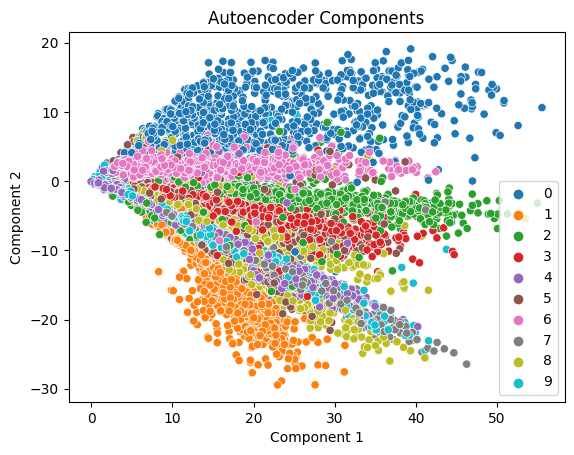

In [11]:
X = torch.vstack(representations)
y = torch.hstack(targets)

ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='tab10')
ax.set_title('Autoencoder Components')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

Wow, that's much clearer then PCA! While there's still some overlap (especially between the 7s and 9s), the clusters are much more distinct. A Mixture of Gaussian model would be able to model this especially well. This is a good sign that the autoencoder is able to capture more of what's important in the data.

Just for fun, let's see what a 3D projection looks like.

In [12]:
model = AutoencoderFC.load_from_checkpoint(
    '../models/20221206-fc-3/model.ckpt',
    n_components=3,
    lr=1e-3,
)

In [13]:
encoder = model.encoder
encoder.eval()

representations = []
targets = []
with torch.no_grad():
    for img, target in dm.predict_dataloader():
        rep = encoder(img)
        representations.append(rep)
        targets.append(target)

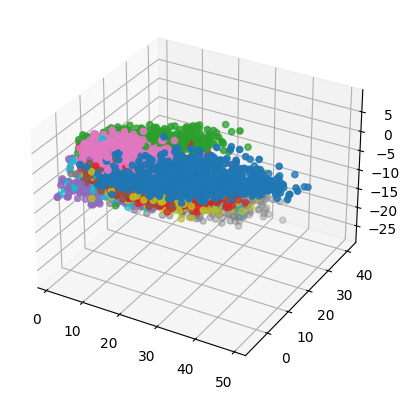

In [14]:
import matplotlib.pyplot as plt

X = torch.vstack(representations)
y = torch.hstack(targets)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='tab10')

While it's harder to visualize, we can see that the clusters are even more distinct. This is a good sign that the autoencoder is able to capture more of what's important in the data.

One potential problem with this is that the model itself is pretty large. Even throwing away the decoder, all the parameters still take up ~0.4 MB. This is due to the model requiring a connection between every layer.

Can't we do anything about that?

# Autoencoders & Convolutional Neural Networks

Recall that the actual implementation of the encoder/decoder aren't strict. We can use any layers we want, as long as the output of the encoder is the same shape as the input of the decoder (and practically, that the data goes through some dimensionality bottleneck).

Enter: Convolutional Neural Networks.

These are neural networks that are specifically designed to take advantage of the spatial information within images. 

![](./figures/cnn.gif)

The underlying assumption is that nearby pixels are more likely to be related than distant pixels. Convolutional neural networks take advantage of this by creating a sliding window to apply a filter to the image. This filter is called a **kernel**, and is essentially a small matrix that is applied to the image. The kernel is then shifted over, and the process is repeated. This is called a **convolution**.

In the image:
- **The green matrix** represents an image
- **The yellow matrix** represents a kernel
- **The pink matrix** represents the output of the convolution 


Let's check out what one of these models would look like in the context of an autoencoder.

In [15]:
from autoencoder_mnist.models.autoencoder_cnn import AutoencoderCNN

n_components = 2
model = AutoencoderCNN(n_components, 1e-3)
ModelSummary(model, max_depth = 1)

  | Name    | Type       | Params | In sizes       | Out sizes     
-------------------------------------------------------------------------
0 | encoder | Sequential | 1.4 K  | [1, 1, 28, 28] | [1, 2]        
1 | decoder | Sequential | 4.5 K  | [1, 2]         | [1, 1, 28, 28]
-------------------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024     Total estimated model params size (MB)

Despite having the same top-level structure, we've cut down on the model size by almost 50x! This is because the convolutional layers are able to share parameters across the image through their learned kernels.

In [16]:
ModelSummary(model, max_depth = 2)

   | Name      | Type            | Params | In sizes        | Out sizes      
-----------------------------------------------------------------------------------
0  | encoder   | Sequential      | 1.4 K  | [1, 1, 28, 28]  | [1, 2]         
1  | encoder.0 | Conv2d          | 160    | [1, 1, 28, 28]  | [1, 16, 10, 10]
2  | encoder.1 | ReLU            | 0      | [1, 16, 10, 10] | [1, 16, 10, 10]
3  | encoder.2 | MaxPool2d       | 0      | [1, 16, 10, 10] | [1, 16, 5, 5]  
4  | encoder.3 | Conv2d          | 1.2 K  | [1, 16, 5, 5]   | [1, 8, 3, 3]   
5  | encoder.4 | ReLU            | 0      | [1, 8, 3, 3]    | [1, 8, 3, 3]   
6  | encoder.5 | MaxPool2d       | 0      | [1, 8, 3, 3]    | [1, 8, 2, 2]   
7  | encoder.6 | Flatten         | 0      | [1, 8, 2, 2]    | [1, 32]        
8  | encoder.7 | Linear          | 66     | [1, 32]         | [1, 2]         
9  | decoder   | Sequential      | 4.5 K  | [1, 2]          | [1, 1, 28, 28] 
10 | decoder.0 | Linear          | 96     | [1, 2]        

The encoder is composed of 9 layers. Much like the fully-connected model, we notice that it's only made up of three trainable `Conv2d` layers and one trainable `Linear` layer. The `Flatten` and `ReLU` layers work the same way as in the fully-connected model.

The `MaxPool2d` function as a way of downsampling the spatial information of the image. Recall that kernels only really look at the nearby pixels and miss out on the larger picture. `MaxPool2d` serves to aggregate this information in larger and larger chunks as we go down the model. This is called **pooling**.

Let's see how this model performs. Once again, we'll use a model I previously trained on my desktop with GPU acceleration.

In [17]:
model = AutoencoderCNN.load_from_checkpoint(
    '../models/20221206-cnn-2/model.ckpt',
    n_components=2,
    lr=1e-3,
)

In [18]:
encoder = model.encoder
encoder.eval()

representations = []
targets = []
with torch.no_grad():
    for img, target in dm.predict_dataloader():
        rep = encoder(img)
        representations.append(rep)
        targets.append(target)

Text(0, 0.5, 'Component 2')

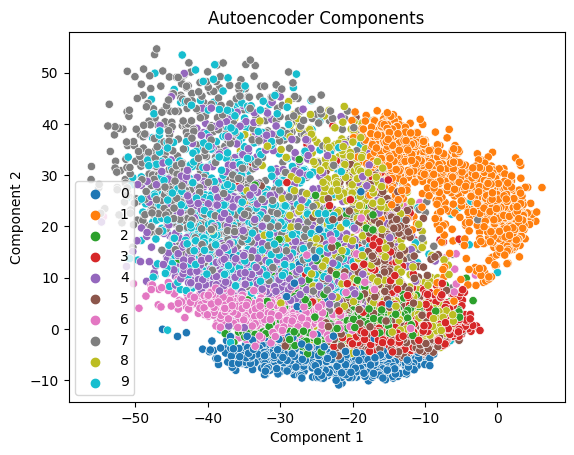

In [19]:
X = torch.vstack(representations)
y = torch.hstack(targets)

ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='tab10')
ax.set_title('Autoencoder Components')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

While this certainly isn't as good as the fully-connected model, it still manages to get the general idea across (and at 50x less the size)!

# Conclusion

I learned a lot over the course of this project. While I had briefly heard of autoencoders in another course, I never really understood what they were or how they worked.

When this course started talking about PCA, I realized that autoencoders were essentially a more complex version of PCA. That gave me the idea to try and implement one myself and really dig into how they work / what they're capable of. To that end, I believe this project has done its job many times over. I'm leaving this course with a much better understanding of the strengths and weaknesses of PCA and autoencoders.

Given more time, I would love to expand my research into how different encoder/decoders affect the performance of the model. For example, how asymmetric encoder/decoder structures affect the performance of the model. When researching, some sources mentioned that asymmetric encoder/decoder structures are better at certain tasks, and I would love to see if/when that's true.

I would also love to explore how autoencoders are used as a piece of more complex models, such as Stable Diffusion (the image-generating AI taking the internet by storm). The ability to take a high-dimensional input and compress it into a low-dimensional latent representation is a powerful tool, and I'm sure more powerful/complex models have been built on top of it.